In [1]:
!nvidia-smi

Mon May  6 19:41:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P3              17W / 160W |    799MiB /  8188MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/nieqianlong/GithubProjects/Drone


In [3]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/home/nieqianlong/GithubProjects/Drone
--2024-05-04 21:20:50--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 205.186.152.122, 2a03:2880:f111:83:face:b00c:0:25de
Connecting to docs.google.com (docs.google.com)|205.186.152.122|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-&export=download [following]
--2024-05-04 21:20:51--  https://drive.usercontent.google.com/download?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.42.225
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.42.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35345757 (34M) [video/mp4]
Saving to: ‘vehicle-counting.mp4’

vehicle-counting.mp 100%[===================>]  33.71

In [18]:
SOURCE_VIDEO_PATH = f"{HOME}/video/1.1.1.mov"

In [4]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.4 🚀 Python-3.8.19 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 7937MiB)
Setup complete ✅ (12 CPUs, 31.1 GB RAM, 301.8/915.3 GB disk)


In [5]:
# %cd {HOME}
# !git clone https://github.com/ifzhang/ByteTrack.git
# %cd {HOME}/ByteTrack

# # workaround related to https://github.com/roboflow/notebooks/issues/80
# !sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

# !pip3 install -q -r requirements.txt
# !python3 setup.py -q develop
# !pip install -q cython_bbox
# !pip install -q onemetric
# # workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
# !pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [6]:
from ultralytics import YOLO
MODEL = 'PERSON_yolov8x.pt'
model = YOLO(MODEL)
model.fuse()

YOLOv8x-worldv2 summary: 522 layers, 224133530 parameters, 224133514 gradients, 272.3 GFLOPs


In [7]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [8]:
from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.20.0


<class 'numpy.ndarray'>


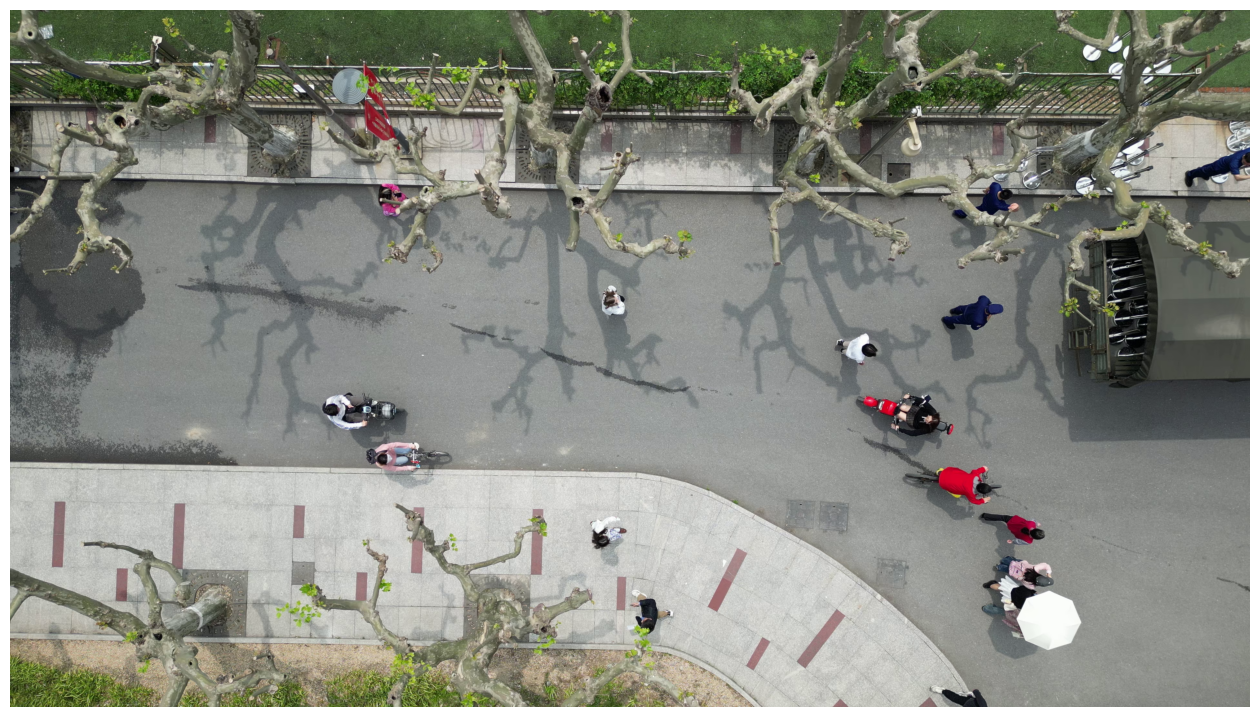

In [9]:
from supervision import get_video_frames_generator
from supervision import plot_image
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
print(type(frame))
plot_image(frame,(16, 16))

In [14]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [10]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

In [11]:
TARGET_VIDEO_PATH = f"{HOME}/output/OUT_0333.mp4"

In [12]:
import supervision as sv
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

In [19]:
from supervision import Detections, BoundingBoxAnnotator, LabelAnnotator
from supervision.draw.color import ColorPalette
from supervision import Color, Position, ColorLookup
from supervision import get_video_frames_generator
from supervision import plot_image
from tqdm.notebook import tqdm

byte_tracker = BYTETracker(BYTETrackerArgs())

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = BoundingBoxAnnotator(color=ColorPalette.DEFAULT, thickness=4)
label_annotator = LabelAnnotator(color=ColorPalette.DEFAULT, text_color=Color.WHITE, text_scale=0.5, text_thickness=1, text_padding=10, text_position=Position.TOP_LEFT, color_lookup=ColorLookup.CLASS)

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(generator, total=video_info.total_frames):

        results = model(frame)[0]

        detections = Detections(
            xyxy=results.boxes.xyxy.cpu().numpy(),
            confidence=results.boxes.conf.cpu().numpy(),
            class_id=results.boxes.cls.cpu().numpy().astype(int)
        )
        
        tracks = byte_tracker.update(
            output_results = detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # format custom labels
        labels = [ f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}" for class_id, confidence, tracker_id 
                  in zip(detections.class_id, detections.confidence, detections.tracker_id)]

        frame = box_annotator.annotate(scene=frame, detections=detections)
        frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)
        sink.write_frame(frame)

  0%|          | 0/3653 [00:00<?, ?it/s]


0: 384x640 4 persons, 16.2ms
Speed: 13.7ms preprocess, 16.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.7ms
Speed: 1.4ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.6ms
Speed: 1.2ms preprocess, 16.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.6ms
Speed: 1.4ms preprocess, 16.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.8ms
Speed: 1.3ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 17.0ms
Speed: 1.3ms preprocess, 17.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.4ms
Speed: 1.2ms preprocess, 16.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.8ms
Speed: 1.1ms preprocess, 16.8ms inference, 0.6ms postprocess per image at shape 


0: 384x640 3 persons, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16.7ms
Speed: 1.2ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16.2ms
Speed: 1.2ms preprocess, 16.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16.7ms
Speed: 1.4ms preprocess, 16.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 17.2ms
Speed: 1.3ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16.8ms
Speed: 1.2ms preprocess, 16.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16.7ms
Speed: 1.3ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (


0: 384x640 4 persons, 15.9ms
Speed: 1.1ms preprocess, 15.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.5ms
Speed: 1.3ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.8ms
Speed: 1.1ms preprocess, 15.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.7ms
Speed: 1.2ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 15.9ms
Speed: 1.1ms preprocess, 15.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 16.6ms
Speed: 1.2ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (


0: 384x640 4 persons, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.6ms
Speed: 1.2ms preprocess, 16.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.6ms
Speed: 1.2ms preprocess, 16.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.3ms
Speed: 1.2ms preprocess, 16.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 0.5ms postprocess per image at shape (


0: 384x640 4 persons, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.6ms
Speed: 1.1ms preprocess, 15.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.7ms
Speed: 1.4ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 17.1ms
Speed: 1.2ms preprocess, 17.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 17.1ms
Speed: 1.2ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 15.6ms
Speed: 1.1ms preprocess, 15.6ms inference, 0.8ms postprocess per image at shape (


0: 384x640 4 persons, 16.7ms
Speed: 1.2ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


ValueError: The number of labels provided (0) does not match the number of detections (4). Each detection should have a corresponding label. This discrepancy can occur if the labels and detections are not aligned or if an incorrect number of labels has been provided. Please ensure that the labels array has the same length as the Detections object.